## Table of Contents
1. [**Knowlege Graph (KG)**](#TOC0)
1. [**BERT**](#TOC1)
1. [**spaCy**](#TOC2)
1. [**NLTK**](#TOC3)
    

![](https://miro.medium.com/max/3868/1*64AZ80NoAO8wH1RVGToSKg.png)<a id="TOC0"></a> <br>
1. [**Introduction**](#KG1)

    1.1 [**What is Knowledge Graph?**](#KG11)
    
    1.2 [**Data Representation in Knowledge Graph?**](#KG12)
    
    1.3 [**Import Dependencies**](#KG13)
    
    1.4 [**Sentence Segmentation**](#KG14)
    
    1.5 [**Entities Extraction**](#KG15)
    
    1.6 [**Relations Extraction**](#KG16)
    
    1.7 [**Build Knowledge Graph**](#KG17)
     
1. [Conclusion](#KG2) 


Relations Extraction

### 1.3 Import Dependencies & Load dataset<a id="KG13"></a> <br>

In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("/var/basefolder_smit/largelm/localdata/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [3]:
candidate_sentences['sentence'].sample(5)

43                                                                                      other actors perform the body.
2967                                                          it is the first installment of the kick-ass film series.
1115                                    salman has decided to mentor his longtime loyal bodyguard shera's son as well.
1678    , prithviraj kapoor, dilip kumar and dev anand; playback singers mohammed rafi, noorjahan, and shamshad begum.
3859                                                               the film is being crowd-funded by public donations.
Name: sentence, dtype: object

### 1.4 Sentence Segmentation <a id="KG14"></a> <br>
The first step in building a knowledge graph is to split the text document or article into sentences. Then, we will shortlist only those sentences in which there is exactly 1 subject and 1 object.

In [4]:

doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


### 1.5 Entities Extraction <a id="KG15"></a> <br>
The extraction of a single word entity from a sentence is not a tough task. We can easily do this with the help of parts of speech (POS) tags. The nouns and the proper nouns would be our entities.

However, when an entity spans across multiple words, then POS tags alone are not sufficient. We need to parse the dependency tree of the sentence.

To build a knowledge graph, the most important things are the nodes and the edges between them.

These nodes are going to be the entities that are present in the Wikipedia sentences. Edges are the relationships connecting these entities to one another. We will extract these elements in an unsupervised manner, i.e., we will use the grammar of the sentences.

The main idea is to go through a sentence and extract the subject and the object as and when they are encountered. However, there are a few challenges ⁠— an entity can span across multiple words, eg., “red wine”, and the dependency parsers tag only the individual words as subjects or objects.

So, I have created a function below to extract the subject and the object (entities) from a sentence while also overcoming the challenges mentioned above. I have partitioned the code into multiple chunks for your convenience:

In [5]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

**Chunk 1**

Defined a few empty variables in this chunk. prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. prefix and modifier will hold the text that is associated with the subject or the object.

**Chunk 2**

Next, we will loop through the tokens in the sentence. We will first check if the token is a punctuation mark or not. If yes, then we will ignore it and move on to the next token. If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).

As and when we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

**Chunk 3**

Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

**Chunk 4**

Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

**Chunk 5**

Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.

Let’s test this function on a sentence:

In [6]:
get_entities("the film had 200 patents")

['film', '200  patents']

Great, it seems to be working as planned. In the above sentence, ‘film’ is the subject and ‘200 patents’ is the object.

Now we can use this function to extract these entity pairs for all the sentences in our data:

In [7]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:28<00:00, 152.76it/s]


The list entity_pairs contains all the subject-object pairs from the Wikipedia sentences. Let’s have a look at a few of them:

In [8]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'men']]

As you can see, there are a few pronouns in these entity pairs such as ‘we’, ‘it’, ‘she’, etc. We’d like to have proper nouns or nouns instead. Perhaps we can further improve the get_entities( ) function to filter out pronouns

### 1.6 Relations Extraction <a id="KG16"></a> <br>
Entity extraction is half the job done. To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes.

Our hypothesis is that the predicate is actually the main verb in a sentence.

For example, in the sentence – “Sixty Hollywood musicals were released in 1929”, the verb is “released in” and this is what we are going to use as the predicate for the triple generated from this sentence.

The function below is capable of capturing such predicates from the sentences. Here, I have used spaCy’s rule-based matching:

In [9]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match = None)  

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

The pattern defined in the function tries to find the ROOT word or the main verb in the sentence. Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. If yes, then it is added to the ROOT word.
Let me show you a glimpse of this function:

In [10]:
get_relation("John completed the task")

'completed'

In [11]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:28<00:00, 151.30it/s]


Let’s take a look at the most frequent relations or predicates that we have just extracted:

In [12]:
pd.Series(relations).value_counts()[:50]

is               364
was              308
released on       90
are               74
include           73
were              68
released          41
's                39
composed by       34
have              31
became            31
has               30
become            28
released in       27
included          23
produced          21
had               21
been              20
called            19
used              19
considered        18
made              18
scheduled         17
be                17
directed by       16
stars             16
hired             14
produced by       14
introduced in     13
written by        13
went              13
wrote             13
received          13
wanted            12
sold              12
set               11
began             11
cast as           11
won               11
began in          11
directed          10
gave              10
includes          10
shot in            9
features           9
said               9
produced in        9
gives        

### 1.7 Build Knowledge Graph <a id="KG17"></a> <br>

We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

Let’s create a dataframe of entities and predicates:

In [13]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

Next, we will use the networkx library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.

It is going to be a directed graph. In other words, the relation between any connected node pair is not two-way, it is only from one node to another.

In [14]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

Let’s plot the network:

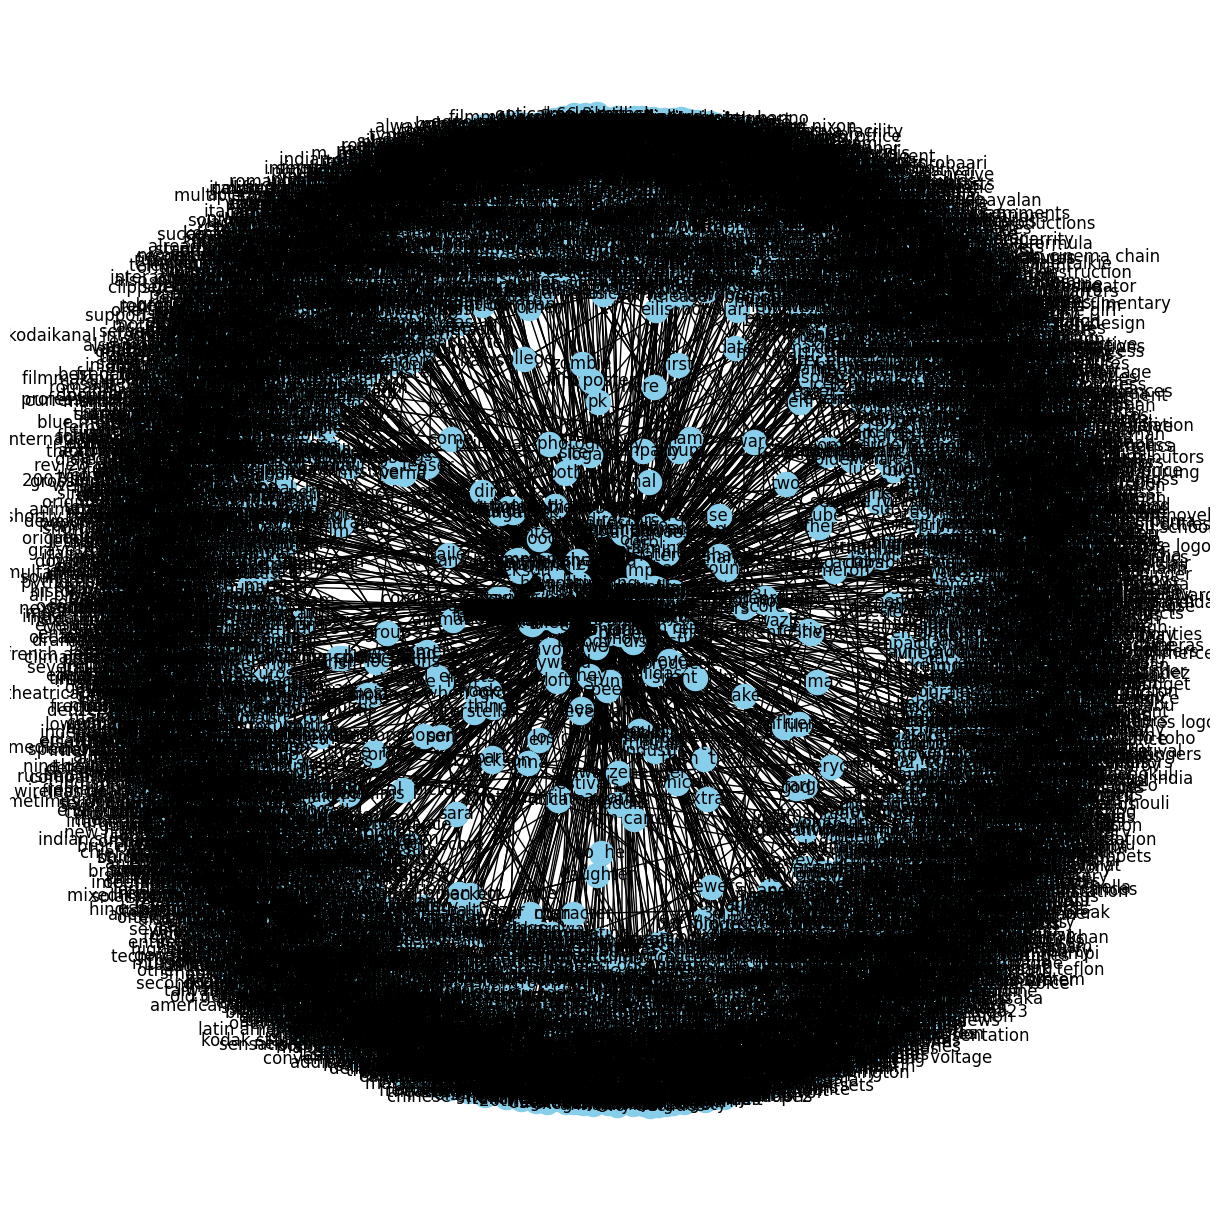

In [15]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Well, this is not exactly what we were hoping for (still looks quite a sight though!).

It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.

So, it’s advisable to use only a few important relations to visualize a graph. I will take one relation at a time. Let’s start with the relation “composed by”:

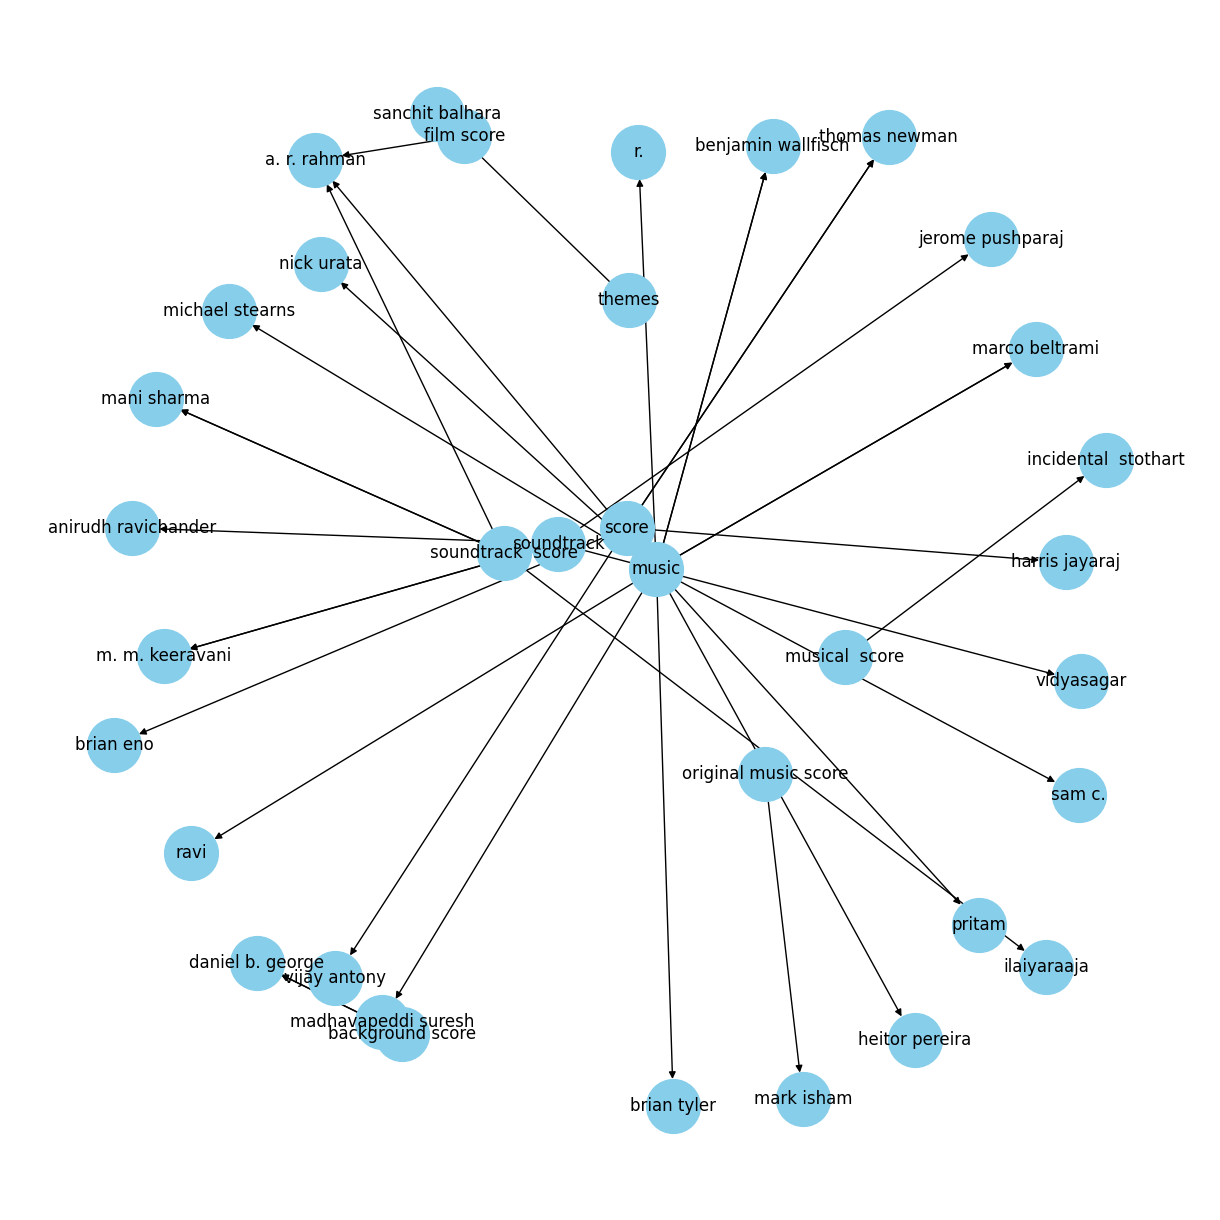

In [16]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

That’s a much cleaner graph. Here the arrows point towards the composers. For instance, A.R. Rahman, who is a renowned music composer, has entities like “soundtrack score”, “film score”, and “music” connected to him in the graph above.

Let’s check out a few more relations.

Now I would like to visualize the graph for the “written by” relation:

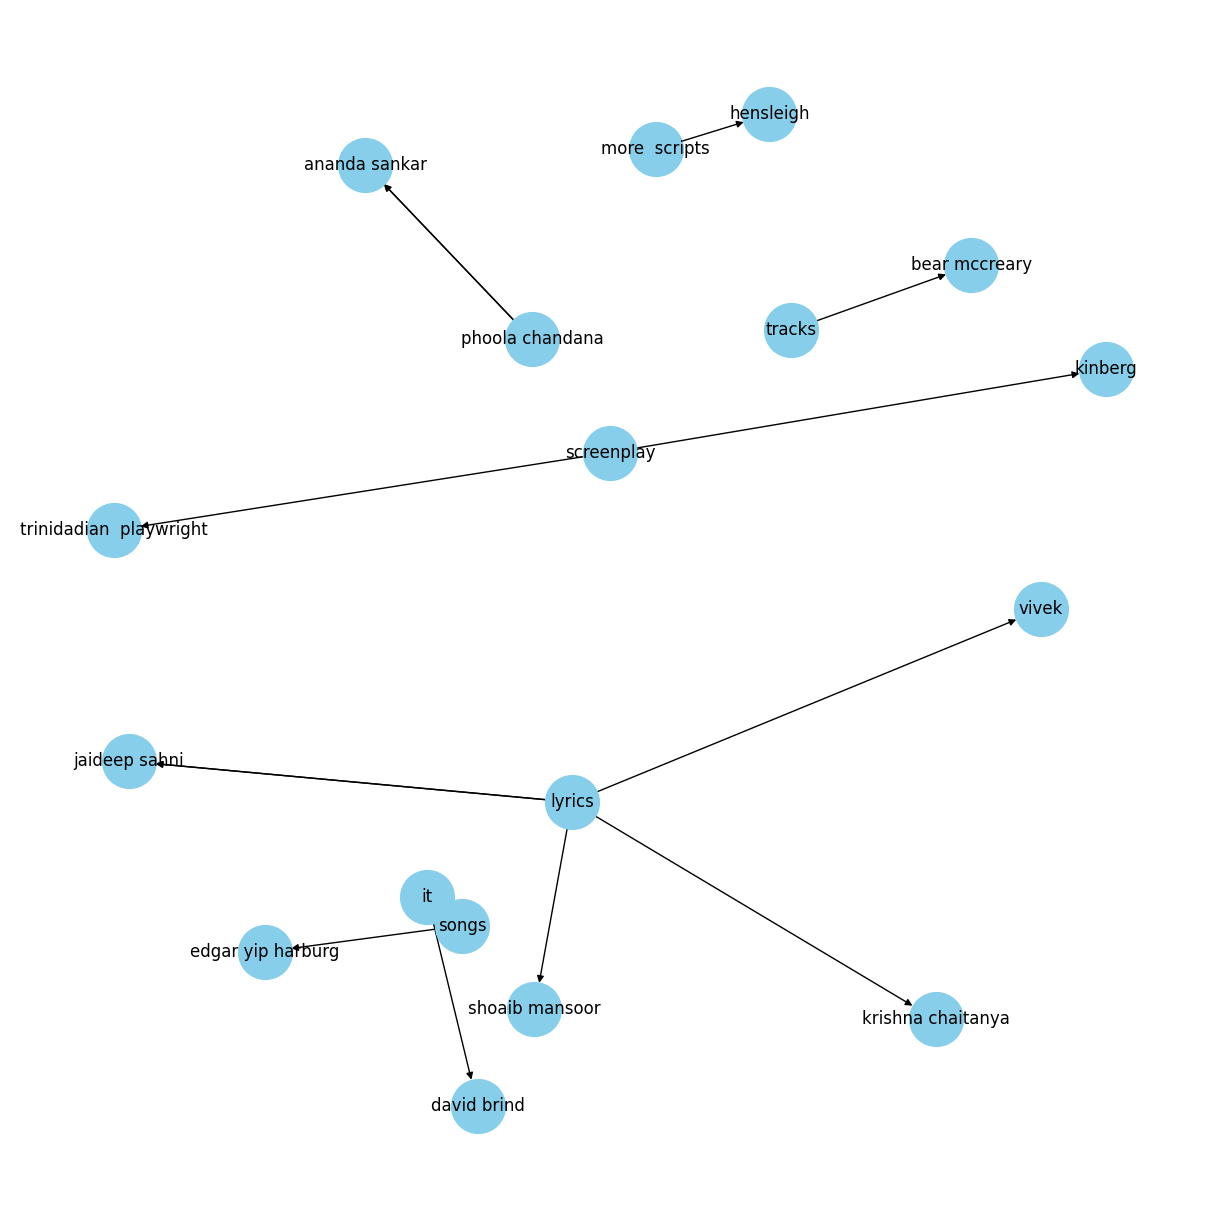

In [17]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

This knowledge graph is giving us some extraordinary information. Guys like Javed Akhtar, Krishna Chaitanya, and Jaideep Sahni are all famous lyricists and this graph beautifully captures this relationship.

Let’s see the knowledge graph of another important predicate, i.e., the “released in”:

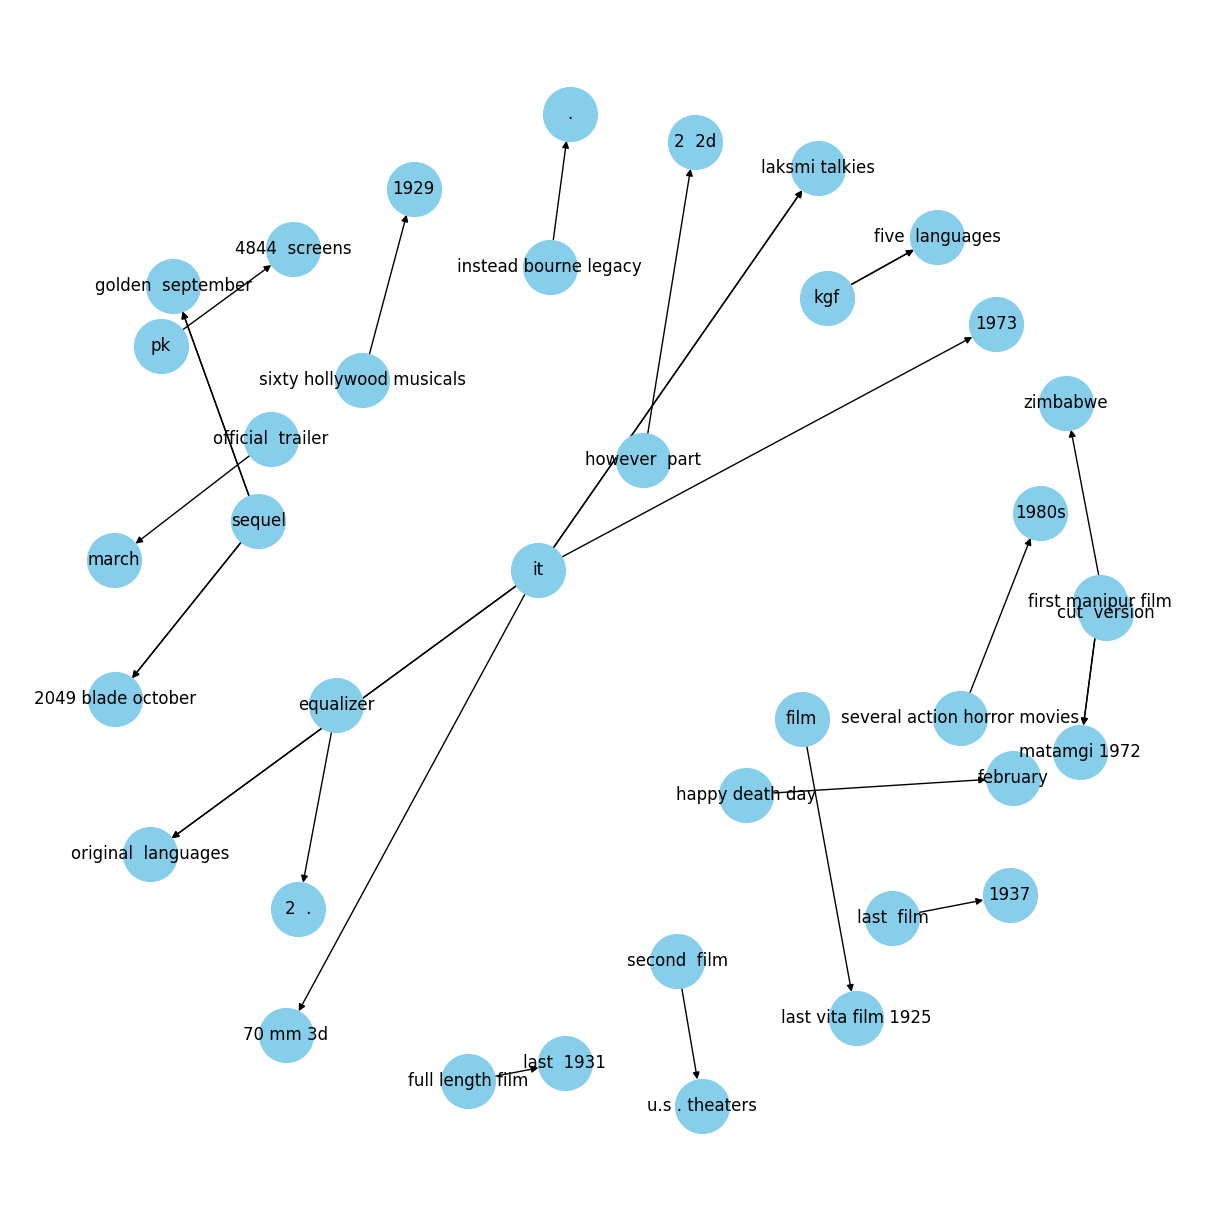

In [18]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## 2. Conclusion <a id="KG2"></a> <br>
### I hope you have a good understanding on how to use Knowledge Graph .

## Please do leave your comments /suggestions and if you like this notebook please do <font color='red'>UPVOTE

![](https://torpedogroup.com/app/uploads/2019/11/BERT-Logo-300x340-2.jpg)<a id="TOC1"></a> <br>

# BERT: Bidirectional Encoder Representations from Transformers

## Table of Contents
1. [**Introduction**](#A1)

    1.1 [**What is BERT?**](#A11)
    
    1.2 [**Architecture**](#A12)
    
    1.3 [**Why we needed BERT?**](#A13)
    
    1.4 [**Core Idea of BERT**](#A14)
    
    1.5 [**How does it work**](#A15)
    
    1.6 [**When can we use it?**](#A16)
    
    1.7 [**How to fine-tune it?**](#A17)
     
1. [**Use Case - Text Classification using BERT**](#A2)
    
1. [References](#A3)  

1. [Conclusion](#A4) 

## 1. Introduction <a id="A1"></a> <br>
At the end of 2018 researchers at Google AI Language open-sourced a new technique for Natural Language Processing (NLP) called BERT (Bidirectional Encoder Representations from Transformers) —  a major breakthrough which took the Deep Learning community by storm because of its incredible performance.

### 1.1 What is BERT? <a id="A11"></a> <br>

**BERT** stands for **B**idirectional **E**ncoder **R**epresentations from **T**ransformers. Let us understand this in detail each word .

* **Bidirectional** - to understand the text you’re looking you’ll have to look back (at the previous words) and forward (at the next words)
* **Transformers** - [The Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. his in a sentence refers to Jim).
* **(Pre-trained) contextualized word embeddings** - [The ELMO paper](https://arxiv.org/pdf/1802.05365v2.pdf) introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence.

### 1.2 Architecture <a id="A12"></a> <br>
The original BERT model was developed and trained by Google using TensorFlow. BERT is released in two sizes **BERTBASE** and **BERTLARGE**. 

The BASE model is used to measure the performance of the architecture comparable to another architecture and the LARGE model produces state-of-the-art results that were reported in the research paper.

One of the main reasons for the good performance of BERT on different NLP tasks was the use of **Semi-Supervised Learning**. This means the model is trained for a specific task that enables it to understand the patterns of the language. After training the model (BERT) has language processing capabilities that can be used to empower other models that we build and train using supervised learning.

**BERT** is basically an Encoder stack of transformer architecture. A transformer architecture is an encoder-decoder network that uses self-attention on the encoder side and attention on the decoder side. 

**BERTBASE** has 12 layers in the Encoder stack while **BERTLARGE** has 24 layers in the Encoder stack. These are more than the Transformer architecture described in the original paper (6 encoder layers). 

**BERT** architectures (BASE and LARGE) also have larger feedforward-networks (768 and 1024 hidden units respectively), and more attention heads (12 and 16 respectively) than the Transformer architecture suggested in the original paper. It contains 512 hidden units and 8 attention heads. 

**BERTBASE** contains 110M parameters while BERTLARGE has 340M parameters.

So in summary
* **BERT-Base**: 12 layer Encoder / Decoder, d = 768, 110M parameters
* **BERT-Large**: 24 layer Encoder / Decoder, d = 1024, 340M parameters

where d is the dimensionality of the final hidden vector output by BERT. Both of these have a Cased and an Uncased version (the Uncased version converts all words to lowercase).

![](https://media.geeksforgeeks.org/wp-content/uploads/20200407004114/bert-base-and-large.jpg)

This model takes CLS token as input first, then it is followed by a sequence of words as input. Here CLS is a classification token. It then passes the input to the above layers. Each layer applies self-attention, passes the result through a feedforward network after then it hands off to the next encoder.

The model outputs a vector of hidden size (768 for BERT BASE). If we want to output a classifier from this model we can take the output corresponding to CLS token.
![](https://media.geeksforgeeks.org/wp-content/uploads/20200407005130/BERT-embedding-output.jpg)

### 1.3 Why we needed BERT? <a id="A13"></a> <br>

One of the biggest challenges in NLP is the **lack of enough training data**. Overall there is enormous amount of text data available, but if we want to create task-specific datasets, we need to split that pile into the very many diverse fields. And when we do this, we end up with only a few thousand or a few hundred thousand human-labeled training examples. Unfortunately, in order to perform well, deep learning based NLP models require much larger amounts of data —  they see major improvements when trained on millions, or billions, of annotated training examples. 

To help bridge this gap in data, researchers have developed various techniques for training general purpose language representation models using the enormous piles of unannotated text on the web (this is known as pre-training). These general purpose pre-trained models can then be fine-tuned on smaller task-specific datasets, e.g., when working with problems like question answering and sentiment analysis. This approach results in great accuracy improvements compared to training on the smaller task-specific datasets from scratch. BERT is a recent addition to these techniques for NLP pre-training; it caused a stir in the deep learning community because it presented state-of-the-art results in a wide variety of NLP tasks, like question answering.

The best part about BERT is that it can be download and used for free —  we can either use the  BERT models to extract high quality language features from our text data, or we can fine-tune these models on a specific task, like sentiment analysis and question answering, with our own data to produce state-of-the-art predictions.

In **summary** the following are the main benefits of using BERT:

**Easy Training**

First, the pre-trained BERT model weights already encode a lot of information about our language. As a result, it takes much less time to train our fine-tuned model - it is as if we have already trained the bottom layers of our network extensively and only need to gently tune them while using their output as features for our classification task. In fact, the authors recommend only 2-4 epochs of training for fine-tuning BERT on a specific NLP task (compared to the hundreds of GPU hours needed to train the original BERT model or a LSTM from scratch!).

**Less Data**

In addition and perhaps just as important, because of the pre-trained weights this method allows us to fine-tune our task on a much smaller dataset than would be required in a model that is built from scratch. A major drawback of NLP models built from scratch is that we often need a prohibitively large dataset in order to train our network to reasonable accuracy, meaning a lot of time and energy had to be put into dataset creation. By fine-tuning BERT, we are now able to get away with training a model to good performance on a much smaller amount of training data.

**Good Results**

Second, this simple fine-tuning procedure (typically adding one fully-connected layer on top of BERT and training for a few epochs) was shown to achieve state of the art results with minimal task-specific adjustments for a wide variety of tasks: classification, language inference, semantic similarity, question answering, etc. Rather than implementing custom and sometimes-obscure architetures shown to work well on a specific task, simply fine-tuning BERT is shown to be a better (or at least equal) alternative.

**A Shift in NLP**

This shift to transfer learning parallels the same shift that took place in computer vision a few years ago. Creating a good deep learning network for computer vision tasks can take millions of parameters and be very expensive to train. Researchers discovered that deep networks learn hierarchical feature representations (simple features like edges at the lowest layers with gradually more complex features at higher layers). Rather than training a new network from scratch each time, the lower layers of a trained network with generalized image features could be copied and transfered for use in another network with a different task. It soon became common practice to download a pre-trained deep network and quickly retrain it for the new task or add additional layers on top - vastly preferable to the expensive process of training a network from scratch. For many, the introduction of deep pre-trained language models in 2018 (ELMO, BERT, ULMFIT, Open-GPT, etc.) signals the same shift to transfer learning in NLP that computer vision saw.


### 1.4 Core Idea of BERT <a id="A14"></a> <br>

What is language modeling really about? Which problem are language models trying to solve? Basically, their task is to “fill in the blank” based on context. For example, given

“The woman went to the store and bought a _____ of shoes.”

a language model might complete this sentence by saying that the word “cart” would fill the blank 20% of the time and the word “pair” 80% of the time.

In the pre-BERT world, a language model would have looked at this text sequence during training from either left-to-right or combined left-to-right and right-to-left. This one-directional approach works well for generating sentences — we can predict the next word, append that to the sequence, then predict the next to next word until we have a complete sentence.

Now enters BERT, a language model which is bidirectionally trained (this is also its key technical innovation). This means we can now have a deeper sense of language context and flow compared to the single-direction language models.

Instead of predicting the next word in a sequence, BERT makes use of a novel technique called **Masked LM** (MLM): it randomly masks words in the sentence and then it tries to predict them. Masking means that the model looks in both directions and it uses the full context of the sentence, both left and right surroundings, in order to predict the masked word. Unlike the previous language models, it takes both the previous and next tokens into account at the same time. The existing combined left-to-right and right-to-left LSTM based models were missing this “same-time part”. (It might be more accurate to say that BERT is non-directional though.)

But why is this non-directional approach so powerful? 

Pre-trained language representations can either be context-free or context-based. Context-based representations can then be unidirectional or bidirectional. Context-free models like word2vec generate a single word embedding representation (a vector of numbers) for each word in the vocabulary.

For example, the word “bank” would have the same context-free representation in “bank account” and “bank of the river.” On the other hand, context-based models generate a representation of each word that is based on the other words in the sentence. For example, in the sentence “I accessed the bank account,” a unidirectional contextual model would represent “bank” based on “I accessed the” but not “account.” However, BERT represents “bank” using both its previous and next context — “I accessed the … account” — starting from the very bottom of a deep neural network, making it deeply bidirectional.
![](https://i0.wp.com/mlexplained.com/wp-content/uploads/2019/01/Screen-Shot-2019-01-03-at-11.22.11-AM.png?fit=750%2C192)

It’s evident from the above image: BERT is bi-directional, GPT is unidirectional (information flows only from left-to-right), and ELMO is shallowly bidirectional.

BERT is based on the Transformer model architecture, instead of LSTMs. We will very soon see the model details of BERT, but in general:

A Transformer works by performing a small, constant number of steps. In each step, it applies an attention mechanism to understand relationships between all words in a sentence, regardless of their respective position. For example, given the sentence,  “I arrived at the bank after crossing the river”, to determine that the word “bank” refers to the shore of a river and not a financial institution, the Transformer can learn to immediately pay attention to the word “river” and make this decision in just one step.

### 1.5 How does it work? <a id="A15"></a> <br>
BERT relies on a Transformer (the attention mechanism that learns contextual relationships between words in a text). A basic Transformer consists of an encoder to read the text input and a decoder to produce a prediction for the task. Since BERT’s goal is to generate a language representation model, it only needs the encoder part. The input to the encoder for BERT is a sequence of tokens, which are first converted into vectors and then processed in the neural network. But before processing can start, BERT needs the input to be massaged and decorated with some extra metadata:

* **Token embeddings**: A  token is added to the input word tokens at the beginning of the first sentence and a  token is inserted at the end of each sentence.
* **Segment embeddings**: A marker indicating Sentence A or Sentence B is added to each token. This allows the encoder to distinguish between sentences.
* **Positional embeddings**: A positional embedding is added to each token to indicate its position in the sentence.
![](https://towardsml.files.wordpress.com/2019/09/input.png?w=810)
The input representation for BERT: The input embeddings are the sum of the token embeddings, the segmentation embeddings and the position embeddings.
 

Essentially, the Transformer stacks a layer that maps sequences to sequences, so the output is also a sequence of vectors with a 1:1 correspondence between input and output tokens at the same index. And as we learnt earlier, BERT does not try to predict the next word in the sentence. 

BERT is pre-trained on two NLP tasks:

**1. Masked Language Modeling (MLM)**

BERT is designed as a deeply bidirectional model. The network effectively captures information from both the right and left context of a token from the first layer itself and all the way through to the last layer.

Traditionally, we had language models either trained to predict the next word in a sentence (right-to-left context used in GPT) or language models that were trained on a left-to-right context. This made our models susceptible to errors due to loss in information.

Let us take an example to understand it better

Let’s say we have a sentence – “I love to read data science blogs on Kaggle”. We want to train a bi-directional language model. Instead of trying to predict the next word in the sequence, we can build a model to predict a missing word from within the sequence itself.

Let’s replace “Kaggle” with “[MASK]”. This is a token to denote that the token is missing. We’ll then train the model in such a way that it should be able to predict “Kaggle” as the missing token: “I love to read data science blogs on [MASK].”

This is the crux of a Masked Language Model. The authors of BERT also include some caveats to further improve this technique:

To prevent the model from focusing too much on a particular position or tokens that are masked, the researchers randomly masked 15% of the words.

The masked words were not always replaced by the masked tokens [MASK] because the [MASK] token would never appear during fine-tuning.

So, the researchers used the below technique:

* 80% of the time the words were replaced with the masked token [MASK]
* 10% of the time the words were replaced with random words
* 10% of the time the words were left unchanged


**2. Next Sentence Prediction (NSP)**

**Masked Language Models (MLMs)** learn to understand the relationship between words. Additionally, BERT is also trained on the task of Next Sentence Prediction for tasks that require an understanding of the relationship between sentences.

In order to understand relationship between two sentences, BERT training process also uses next sentence prediction. A pre-trained model with this kind of understanding is relevant for tasks like question answering. During training the model gets as input pairs of sentences and it learns to predict if the second sentence is the next sentence in the original text as well.

As we have seen earlier, BERT separates sentences with a special [SEP] token. During training the model is fed with two input sentences at a time such that:

* 50% of the time the second sentence comes after the first one.
* 50% of the time it is a a random sentence from the full corpus.

BERT is then required to predict whether the second sentence is random or not, with the assumption that the random sentence will be disconnected from the first sentence:
![](https://towardsml.files.wordpress.com/2019/09/nsp-1.png)

To predict if the second sentence is connected to the first one or not, basically the complete input sequence goes through the Transformer based model, the output of the [CLS] token is transformed into a 2×1 shaped vector using a simple classification layer, and the IsNext-Label is assigned using softmax.

The model is trained with both Masked LM and Next Sentence Prediction together. This is to minimize the combined loss function of the two strategies — “together is better”.

### 1.6 When can we use it? <a id="A16"></a> <br>

BERT outperformed the state-of-the-art across a wide variety of tasks under general language understanding like

* **Natural Language Inference**
* **Sentiment Analysis**
* **Question Answering** 
* **Paraphrase detection**
* **Linguistic Acceptability**

### 1.7 How to fine-tune BERT? <a id="A17"></a> <br>
![](https://www.researchgate.net/publication/340295341/figure/fig1/AS:874992090771456@1585625779336/BERT-architecture-1.jpg)
Using BERT for a specific task is relatively straightforward:

BERT can be used for a wide variety of language tasks, while only adding a small layer to the core model:
1. Classification tasks such as sentiment analysis are done similarly to Next Sentence classification, by adding a classification layer on top of the Transformer output for the [CLS] token.
1. In Question Answering tasks (e.g. SQuAD v1.1), the software receives a question regarding a text sequence and is required to mark the answer in the sequence. Using BERT, a Q&A model can be trained by learning two extra vectors that mark the beginning and the end of the answer.
![](https://blog.scaleway.com/content/images/2019/08/squadbert.jpeg)
1. In Named Entity Recognition (NER), the software receives a text sequence and is required to mark the various types of entities (Person, Organization, Date, etc) that appear in the text. Using BERT, a NER model can be trained by feeding the output vector of each token into a classification layer that predicts the NER label.
1. In the fine-tuning training, most hyper-parameters stay the same as in BERT training, and the paper gives specific guidance on the hyper-parameters that require tuning. The BERT team has used this technique to achieve state-of-the-art results on a wide variety of challenging natural language tasks.

## 2. Use Case - Text Classification using BERT <a id="A2"></a> <br>


Let us install the pytorch interface for BERT by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) I have selected the pytorch interface because it strikes a nice balance between the high-level APIs and tensorflow code .

In [19]:
!pip install pytorch-pretrained-bert pytorch-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 106.1 MB/s eta 0:00:0000:0100:01
  Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
  Using cached s3transfer-0.6.1-py3-none-any.whl (79 kB)


In [21]:
# Import Libraries

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

2023-08-02 12:49:44.747731: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-02 12:49:44.795062: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 12:49:45.971445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load Dataset:

I will be using **The Corpus of Linguistic Acceptability (CoLA) dataset** for single sentence classification. 

It's a set of sentences labeled as grammatically correct or incorrect. The data is as follows:

Column 1: the code representing the source of the sentence.

Column 2: the acceptability judgment label (0=unacceptable, 1=acceptable).

Column 3: the acceptability judgment as originally notated by the author.

Column 4: the sentence.

In [22]:
df = pd.read_csv("/var/basefolder_smit/largelm/localdata/in_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [23]:
df.shape

(527, 4)

In [24]:
df.sample(10)

,sentence_source,label,label_notes,sentence
161,l-93,0,*,The books lifted onto the table.
11,cj99,1,NaN,John was lots more obnoxious than Fred.
282,ks08,1,NaN,John was found in the office.
375,c_13,1,NaN,I ate a salad that was filled with lima beans.
401,m_02,1,NaN,The wealthy young man bought that piano for his secret fiancée.
183,l-93,0,*,Herman whipped the sugar and the cream.
10,cj99,1,NaN,"The more Fred is obnoxious, the less attention you should pay to him."
150,l-93,1,NaN,I mixed the sugar into the butter.
312,ks08,1,NaN,That is the reason why he resigned.
371,c_13,0,*,Was sunk.


In [25]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

Next, import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 304235.65B/s]


Tokenize the first sentence:
['[CLS]', 'the', 'sailors', 'rode', 'the', 'breeze', 'clear', 'of', 'the', 'rocks', '.', '[SEP]']


BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

* **input ids**: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
* **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
* **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
* **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

Although we can have variable length input sentences, BERT does requires our input arrays to be the same size. I addressed this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length.

* To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length.

* If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

I padded and truncated the sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) .

pad_sequences is a utility function that we're borrowing from Keras. It simply handles the truncating and padding of Python lists.

In [27]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [28]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [29]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [30]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [31]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [32]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [33]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### Train Model
Now that our input data is properly formatted, it's time to fine tune the BERT model.

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.

We'll load **BertForSequenceClassification**. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

**Structure of Fine-Tuning Model**

As we've showed beforehand, the first token of every sequence is the special classification token ([CLS]). Unlike the hidden state vector corresponding to a normal word token, the hidden state corresponding to this special token is designated by the authors of BERT as an aggregate representation of the whole sentence used for classification tasks. As such, when we feed in an input sentence to our model during training, the output is the length 768 hidden state vector corresponding to this token. The additional layer that we've added on top consists of untrained linear neurons of size [hidden_state, number_of_labels], so [768,2], meaning that the output of BERT plus our classification layer is a vector of two numbers representing the "score" for "grammatical/non-grammatical" that are then fed into cross-entropy loss.

**The Fine-Tuning Process**

Because the pre-trained BERT layers already encode a lot of information about the language, training the classifier is relatively inexpensive. Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.

Sometimes practicioners will opt to "freeze" certain layers when fine-tuning, or to apply different learning rates, apply diminishing learning rates, etc. all in an effort to preserve the good quality weights in the network and speed up training (often considerably). In fact, recent research on BERT specifically has demonstrated that freezing the majority of the weights results in only minimal accuracy declines, but there are exceptions and broader rules of transfer learning that should also be considered. For example, if your task and fine-tuning dataset is very different from the dataset used to train the transfer learning model, freezing the weights may not be a good idea. We'll cover the broader scope of transfer learning in NLP in a future post.

OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

In [34]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

100%|██████████| 407873900/407873900 [00:28<00:00, 14428771.83B/s]


Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4

In [35]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]

In [36]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

t_total value of -1 results in schedule not being applied


For each pass in the training loop we have a training phase and a validation phase. 

At each pass we need to:

**Training loop:**

* Tell the model to compute gradients by setting the model in train mode
* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
* Forward pass (feed input data through the network)
* Backward pass (backpropagation)
* Tell the network to update parameters with optimizer.step()
* Track variables for monitoring progress

**Evalution loop:**

* Tell the model not to compute gradients by setting th emodel in evaluation mode
* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Forward pass (feed input data through the network)
* Compute loss on our validation data and track variables for monitoring progress

In [37]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [38]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs 
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]/root/anaconda3/envs/venv/lib/python3.11/site-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.6471572915712992


Epoch:  50%|█████     | 1/2 [00:43<00:43, 43.69s/it]

Validation Accuracy: 0.7083333333333333
Train loss: 0.5996756633122762


Epoch: 100%|██████████| 2/2 [01:26<00:00, 43.43s/it]

Validation Accuracy: 0.7083333333333333


## Training Evaluation

Let's take a look at our training loss over all batches:

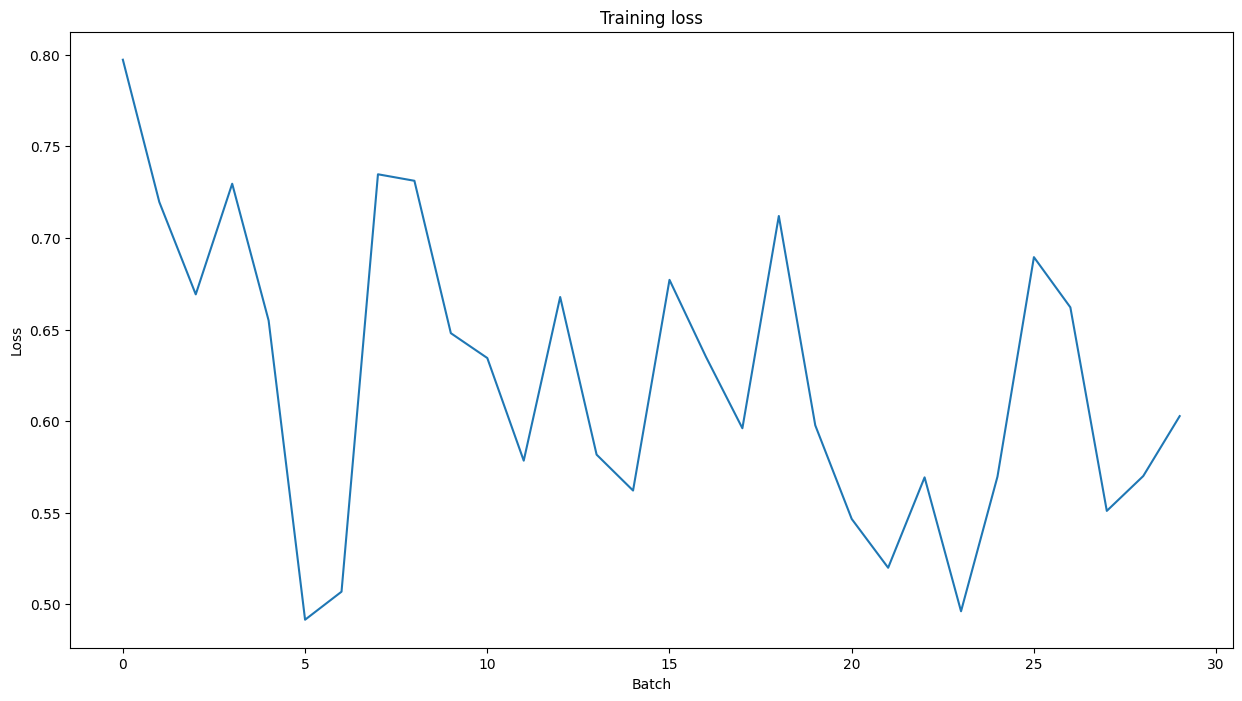

In [39]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Predict and Evaluate on Holdout Set
Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

In [40]:
df = pd.read_csv("/var/basefolder_smit/largelm/localdata/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [41]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [42]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
 # batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [43]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

## 3. References <a id="A3"></a> <br>

* https://towardsml.com/2019/09/17/bert-explained-a-complete-guide-with-theory-and-tutorial/
* https://www.analyticsvidhya.com/blog/2019/09/demystifying-bert-groundbreaking-nlp-framework/
* https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03
* https://towardsml.com/2019/09/17/bert-explained-a-complete-guide-with-theory-and-tutorial/

## 4. Conclusion <a id="A4"></a> <br>
### I hope you have a good understanding on how to use BERT by now .

## Please do leave your comments /suggestions and if you like this notebook please do <font color='red'>UPVOTE

![](https://miro.medium.com/max/595/1*ax2uBqfp963n4PQVqmGplQ.png)<a id="TOC2"></a> <br>

## Table of Contents
1. [**What is spaCy**](#1)

    1.1 [**What spaCy is NOT**](#11)
    
    1.2 [**Installation**](#12)
    
    1.3 [**Statistical Models**](#13)
    
    1.4 [**Dependency Parsing**](#14)
    
    1.5 [**spaCy’s Processing Pipeline**](#15)
        
1. [**Features**](#2)
    
    2.1 [**Tokenization**](#21)
    
    2.2 [**Part-Of-Speech (POS) Tagging**](#22)
    
    2.3 [**Dependency Parsing**](#23)
    
    2.4 [**Lemmatization**](#24)
    
    2.5 [**Sentence Boundary Detection (SBD)**](#25)
    
    2.6 [**Named Entity Recognition (NER)**](#26)
    
    2.7 [**Entity Linking (EL)**](#27)
    
    2.8 [**Similarity**](#28)
    
    2.9 [**Text Classification**](#29)
    
    2.10 [**Training**](#210)
    
    2.11 [**Serialization**](#211)
    
         
1. [References](#3)  

1. [Conclusion](#4)          

## 1. What is spaCy <a id="1"></a> <br>
    
spaCy is a free, open-source library for advanced Natural Language Processing (NLP) in Python. It’s written in Cython and is designed to build information extraction or natural language understanding systems. It’s built for production use and provides a concise and user-friendly API.

If you’re working with a lot of text, you’ll eventually want to know more about it. For example, what’s it about? What do the words mean in context? Who is doing what to whom? What companies and products are mentioned? Which texts are similar to each other?

spaCy is designed specifically for production use and helps you build applications that process and “understand” large volumes of text. It can be used to build information extraction or natural language understanding systems, or to pre-process text for deep learning.

### 1.1 What spaCy is NOT <a id="11"></a> <br>

* **spaCy is not a platform** or “an API”. Unlike a platform, spaCy does not provide a software as a service, or a web application. It’s an open-source library designed to help you build NLP applications, not a consumable service.

* **spaCy is not an out-of-the-box chat bot engine**. While spaCy can be used to power conversational applications, it’s not designed specifically for chat bots, and only provides the underlying text processing capabilities.

* **spaCy is not research software**. It’s built on the latest research, but it’s designed to get things done. This leads to fairly different design decisions than NLTK or CoreNLP, which were created as platforms for teaching and research. The main difference is that spaCy is integrated and opinionated. spaCy tries to avoid asking the user to choose between multiple algorithms that deliver equivalent functionality. Keeping the menu small lets spaCy deliver generally better performance and developer experience.

* **spaCy is not a company.** It’s an open-source library. Our company publishing spaCy and other software is called Explosion AI.



### 1.2 Installation <a id="12"></a> <br>

Spacy, its data, and its models can be easily installed using python package index and setup tools. Use the following command to install spacy in your machine:

In [ ]:
!pip install -U spacy

### 1.3 Statistical models <a id="13"></a> <br>

Some of spaCy’s features work independently, others require statistical models to be loaded, which enable spaCy to predict linguistic annotations – for example, whether a word is a verb or a noun. spaCy currently offers statistical models for a variety of languages, which can be installed as individual Python modules. Models can differ in size, speed, memory usage, accuracy and the data they include. The model you choose always depends on your use case and the texts you’re working with. For a general-purpose use case, the small, default models are always a good start. They typically include the following components:

* **Binary weights** for the part-of-speech tagger, dependency parser and named entity recognizer to predict those annotations in context.
* **Lexical entries** in the vocabulary, i.e. words and their context-independent attributes like the shape or spelling.
* **Data files** like lemmatization rules and lookup tables.
* **Word vectors**, i.e. multi-dimensional meaning representations of words that let you determine how similar they are to each other.
* **Configuration** options, like the language and processing pipeline settings, to put spaCy in the correct state when you load in the model.

These models are the power engines of spaCy. These models enable spaCy to perform several NLP related tasks, such as part-of-speech tagging, named entity recognition, and dependency parsing.

I’ve listed below the different statistical models in spaCy along with their specifications:

* en_core_web_sm: English multi-task CNN trained on OntoNotes. Size – 11 MB

* en_core_web_md: English multi-task CNN trained on OntoNotes, with GloVe vectors trained on Common Crawl. Size – 91 MB

* en_core_web_lg: English multi-task CNN trained on OntoNotes, with GloVe vectors trained on Common Crawl. Size – 789 MB

Importing these models is super easy. We can import a model by just executing spacy.load(‘model_name’) as shown below:

In [44]:
!python -m spacy download en_core_web_lg

2023-08-02 12:57:51.196019: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-02 12:57:51.247492: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 12:57:52.188163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-02 12:57:53.536841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at http

In [45]:
!python -m spacy download en_core_web_sm

2023-08-02 12:58:16.397130: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-02 12:58:16.449720: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 12:58:17.388229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-02 12:58:18.741122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at http

In [46]:
import spacy
nlp = spacy.load('en_core_web_sm')


### 1.4 Linguistic annotations <a id="14"></a> <br>


spaCy provides a variety of linguistic annotations to give you insights into a text’s grammatical structure. This includes the word types, like the parts of speech, and how the words are related to each other. For example, if you’re analyzing text, it makes a huge difference whether a noun is the subject of a sentence, or the object – or whether “google” is used as a verb, or refers to the website or company in a specific context.

Once you have downloaded and installed a model, you can load it via spacy.load(). This will return a Language object containing all components and data needed to process text. We usually call it nlp. Calling the nlp object on a string of text will return a processed Doc:

In [47]:
import spacy
nlp = spacy.load("en_core_web_sm")

doc = nlp("Company Y is planning to acquire stake in X company for $23 billion")
for token in doc:
    print(token.text, token.pos_, token.dep_)

Company NOUN compound
Y PROPN nsubj
is AUX aux
planning VERB ROOT
to PART aux
acquire VERB xcomp
stake NOUN dobj
in ADP prep
X NOUN compound
company NOUN pobj
for ADP prep
$ SYM quantmod
23 NUM compound
billion NUM pobj


Even though a Doc is processed – e.g. split into individual words and annotated – it still holds all information of the original text, like whitespace characters. You can always get the offset of a token into the original string, or reconstruct the original by joining the tokens and their trailing whitespace. This way, you’ll never lose any information when processing text with spaCy.

spaCy’s Processing Pipeline
### 1.5 spaCy’s Processing Pipeline <a id="15"></a> <br>
The first step for a text string, when working with spaCy, is to pass it to an NLP object. This object is essentially a pipeline of several text pre-processing operations through which the input text string has to go through.

![](https://d33wubrfki0l68.cloudfront.net/16b2ccafeefd6d547171afa23f9ac62f159e353d/48b91/pipeline-7a14d4edd18f3edfee8f34393bff2992.svg)

As you can see in the figure above, the NLP pipeline has multiple components, such as tokenizer, tagger, parser, ner, etc. So, the input text string has to go through all these components before we can work on it.

Let me show you how we can create an nlp object:



In [48]:
import spacy
nlp = spacy.load('en_core_web_sm')

# Create an nlp object
doc = nlp("He went to play cricket with friends in the stadium")

You can use the below code to figure out the active pipeline components:

In [49]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

Just in case you wish to disable the pipeline components and keep only the tokenizer up and running, then you can use the code below to disable the pipeline components:

In [50]:
nlp.disable_pipes('tagger', 'parser')

['tagger', 'parser']

Let’s again check the active pipeline component:

In [51]:
nlp.pipe_names

['tok2vec', 'attribute_ruler', 'lemmatizer', 'ner']

## 2. Features <a id="2"></a> <br>
### 2.1 Tokenization <a id="21"></a> <br>

	Segmenting text into words, punctuations marks etc.

During processing, spaCy first tokenizes the text, i.e. segments it into words, punctuation and so on. This is done by applying rules specific to each language.

In [52]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Reliance is looking at buying U.K. based analytics startup for $7 billion")
for token in doc:
    print(token.text)

Reliance
is
looking
at
buying
U.K.
based
analytics
startup
for
$
7
billion


First, the raw text is split on whitespace characters, similar to text.split(' '). Then, the tokenizer processes the text from left to right. On each substring, it performs two checks:

* Does the substring match a tokenizer exception rule? For example, “don’t” does not contain whitespace, but should be split into two tokens, “do” and “n’t”, while “U.K.” should always remain one token.

* Can a prefix, suffix or infix be split off? For example punctuation like commas, periods, hyphens or quotes.

If there’s a match, the rule is applied and the tokenizer continues its loop, starting with the newly split substrings. This way, spaCy can split complex, nested tokens like combinations of abbreviations and multiple punctuation marks.

![](https://d33wubrfki0l68.cloudfront.net/fedbc2aef51d678ae40a03cb35253dae2d52b18b/3d4b2/tokenization-57e618bd79d933c4ccd308b5739062d6.svg)

### 2.2 Part-Of-Speech (POS) Tagging <a id="22"></a> <br>

Part of speech or POS is a grammatical role that explains how a particular word is used in a sentence. There are eight parts of speech.

* Noun
* Pronoun
* Adjective
* Verb
* Adverb
* Preposition
* Conjunction
* Interjection

Part of speech tagging is the process of assigning a POS tag to each token depending on its usage in the sentence. POS tags are useful for assigning a syntactic category like noun or verb to each word.

After tokenization, spaCy can parse and tag a given Doc. This is where the statistical model comes in, which enables spaCy to make a prediction of which tag or label most likely applies in this context. A model consists of binary data and is produced by showing a system enough examples for it to make predictions that generalize across the language – for example, a word following “the” in English is most likely a noun.

Linguistic annotations are available as Token attributes. Like many NLP libraries, spaCy encodes all strings to hash values to reduce memory usage and improve efficiency. So to get the readable string representation of an attribute, we need to add an underscore _ to its name.

In English grammar, the parts of speech tell us what is the function of a word and how it is used in a sentence. Some of the common parts of speech in English are Noun, Pronoun, Adjective, Verb, Adverb, etc.

POS tagging is the task of automatically assigning POS tags to all the words of a sentence. It is helpful in various downstream tasks in NLP, such as feature engineering, language understanding, and information extraction.

Performing POS tagging, in spaCy, is a cakewalk.

In spaCy, POS tags are available as an attribute on the Token object:

In [53]:
import spacy 
nlp = spacy.load('en_core_web_sm')

# Create an nlp object
doc = nlp("Reliance is looking at buying U.K. based analytics startup for $7 billion")
 
# Iterate over the tokens
for token in doc:
    # Print the token and its part-of-speech tag
    print(token, token.tag_, token.pos_, spacy.explain(token.tag_))

Reliance NN NOUN noun, singular or mass
is VBZ AUX verb, 3rd person singular present
looking VBG VERB verb, gerund or present participle
at IN ADP conjunction, subordinating or preposition
buying VBG VERB verb, gerund or present participle
U.K. NNP PROPN noun, proper singular
based VBN VERB verb, past participle
analytics NNS NOUN noun, plural
startup VB VERB verb, base form
for IN ADP conjunction, subordinating or preposition
$ $ SYM symbol, currency
7 CD NUM cardinal number
billion CD NUM cardinal number


Using spaCy’s built-in **displaCy** visualizer,The quickest way to visualize Doc is to use displacy.serve. This will spin up a simple web server and let you view the result straight from your browser. displaCy can either take a single Doc or a list of Doc objects as its first argument. This lets you construct them however you like – using any model or modifications you like.Here’s what our example sentence and its dependencies look like:

In [54]:
import spacy
from spacy import displacy

doc = nlp("Reliance is looking at buying U.K. based analytics startup for $7 billion")
displacy.render(doc, style="dep" , jupyter=True)

### 2.3 Dependency Parsing <a id="23"></a> <br>

Dependency parsing is the process of extracting the dependency parse of a sentence to represent its grammatical structure. It defines the dependency relationship between headwords and their dependents. The head of a sentence has no dependency and is called the root of the sentence. The verb is usually the head of the sentence. All other words are linked to the headword.

The dependencies can be mapped in a directed graph representation:

* Words are the nodes.
* The grammatical relationships are the edges.

Dependency parsing helps you know what role a word plays in the text and how different words relate to each other. It’s also used in shallow parsing and named entity recognition.

Here’s how you can use dependency parsing to see the relationships between words:
![](https://www.researchgate.net/profile/Michael_Ringgaard/publication/220816955/figure/fig2/AS:667852638019597@1536239885253/Dependency-Parse-Tree-with-Alignment-for-a-Sentence-with-Preposition-Modifier.png)
Performing dependency parsing is again pretty easy in spaCy. We will use the same sentence here that we used for POS tagging:

In [55]:
import spacy 
nlp = spacy.load('en_core_web_sm')

# Create an nlp object
doc = nlp("Reliance is looking at buying U.K. based analytics startup for $7 billion")
 
# Iterate over the tokens
for token in doc:
    # Print the token and its part-of-speech tag
    print(token.text, "-->", token.dep_)

Reliance --> nsubj
is --> aux
looking --> ROOT
at --> prep
buying --> pcomp
U.K. --> npadvmod
based --> amod
analytics --> nsubj
startup --> conj
for --> prep
$ --> quantmod
7 --> compound
billion --> pobj


The dependency tag ROOT denotes the main verb or action in the sentence. The other words are directly or indirectly connected to the ROOT word of the sentence. You can find out what other tags stand for by executing the code below:

In [56]:
spacy.explain("nsubj"), spacy.explain("ROOT"), spacy.explain("aux"), spacy.explain("advcl"), spacy.explain("dobj")

('nominal subject',
 'root',
 'auxiliary',
 'adverbial clause modifier',
 'direct object')

### 2.4 Lemmatization <a id="24"></a> <br>

**Lemmatization** is the process of reducing inflected forms of a word while still ensuring that the reduced form belongs to the language. This reduced form or root word is called a lemma.

For example, organizes, organized and organizing are all forms of organize. Here, organize is the lemma. The inflection of a word allows you to express different grammatical categories like tense (organized vs organize), number (trains vs train), and so on. Lemmatization is necessary because it helps you reduce the inflected forms of a word so that they can be analyzed as a single item. It can also help you normalize the text.

spaCy has the attribute lemma_ on the Token class. This attribute has the lemmatized form of a token:

In [57]:
import spacy 
nlp = spacy.load('en_core_web_sm')

# Create an nlp object
doc = nlp("Reliance is looking at buying U.K. based analytics startup for $7 billion")
 
# Iterate over the tokens
for token in doc:
    # Print the token and its part-of-speech tag
    print(token.text, "-->", token.lemma_)

Reliance --> reliance
is --> be
looking --> look
at --> at
buying --> buy
U.K. --> U.K.
based --> base
analytics --> analytic
startup --> startup
for --> for
$ --> $
7 --> 7
billion --> billion


### 2.5 Sentence Boundary Detection (SBD) <a id="25"></a> <br>

**Sentence Boundary Detection** is the process of locating the start and end of sentences in a given text. This allows you to you divide a text into linguistically meaningful units. You’ll use these units when you’re processing your text to perform tasks such as part of speech tagging and entity extraction.

In spaCy, the sents property is used to extract sentences. Here’s how you would extract the total number of sentences and the sentences for a given input text:


In [58]:
import spacy 
nlp = spacy.load('en_core_web_sm')

# Create an nlp object
doc = nlp("Reliance is looking at buying U.K. based analytics startup for $7 billion.This is India.India is great")
 
sentences = list(doc.sents)
len(sentences)

3

In [59]:
for sentence in sentences:
     print (sentence)

Reliance is looking at buying U.K. based analytics startup for $7 billion.
This is India.
India is great


### 2.6 Named Entity Recognition (NER) <a id="26"></a> <br>

A named entity is a “real-world object” that’s assigned a name – for example, a person, a country, a product or a book title. spaCy can recognize various types of named entities in a document, by asking the model for a prediction. Because models are statistical and strongly depend on the examples they were trained on, this doesn’t always work perfectly and might need some tuning later, depending on your use case.

Named entities are available as the ents property of a Doc:

In [60]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Reliance is looking at buying U.K. based analytics startup for $7 billion")

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Reliance 0 8 ORG
U.K. 30 34 GPE
$7 billion 63 73 MONEY


### 2.7 Entity Detection <a id="27"></a> <br>

**Entity detection**, also called entity recognition, is a more advanced form of language processing that identifies important elements like places, people, organizations, and languages within an input string of text. This is really helpful for quickly extracting information from text, since you can quickly pick out important topics or indentify key sections of text.

Let’s try out some entity detection using a few paragraphs from this recent article in the Washington Post. We’ll use .label to grab a label for each entity that’s detected in the text, and then we’ll take a look at these entities in a more visual format using spaCy‘s displaCy visualizer.

In [61]:
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")
doc= nlp(u"""The Amazon rainforest,[a] alternatively, the Amazon Jungle, also known in English as Amazonia, is a moist broadleaf tropical rainforest in the Amazon biome that covers most of the Amazon basin of South America. This basin encompasses 7,000,000 km2 (2,700,000 sq mi), of which 5,500,000 km2 (2,100,000 sq mi) are covered by the rainforest. This region includes territory belonging to nine nations.

The majority of the forest is contained within Brazil, with 60% of the rainforest, followed by Peru with 13%, Colombia with 10%, and with minor amounts in Bolivia, Ecuador, French Guiana, Guyana, Suriname, and Venezuela. Four nations have "Amazonas" as the name of one of their first-level administrative regions and France uses the name "Guiana Amazonian Park" for its rainforest protected area. The Amazon represents over half of the planet's remaining rainforests,[2] and comprises the largest and most biodiverse tract of tropical rainforest in the world, with an estimated 390 billion individual trees divided into 16,000 species.[3]

Etymology
The name Amazon is said to arise from a war Francisco de Orellana fought with the Tapuyas and other tribes. The women of the tribe fought alongside the men, as was their custom.[4] Orellana derived the name Amazonas from the Amazons of Greek mythology, described by Herodotus and Diodorus.[4]

History
See also: History of South America § Amazon, and Amazon River § History
Tribal societies are well capable of escalation to all-out wars between tribes. Thus, in the Amazonas, there was perpetual animosity between the neighboring tribes of the Jivaro. Several tribes of the Jivaroan group, including the Shuar, practised headhunting for trophies and headshrinking.[5] The accounts of missionaries to the area in the borderlands between Brazil and Venezuela have recounted constant infighting in the Yanomami tribes. More than a third of the Yanomamo males, on average, died from warfare.[6]""")

entities=[(i, i.label_, i.label) for i in doc.ents]
entities

[(Amazon, 'ORG', 383),
 (Amazon, 'ORG', 383),
 (Jungle, 'PRODUCT', 386),
 (English, 'LANGUAGE', 389),
 (Amazonia, 'GPE', 384),
 (Amazon, 'ORG', 383),
 (Amazon, 'ORG', 383),
 (South America, 'LOC', 385),
 (7,000,000, 'CARDINAL', 397),
 (2,700,000 sq mi, 'QUANTITY', 395),
 (5,500,000, 'CARDINAL', 397),
 (2,100,000 sq mi, 'QUANTITY', 395),
 (nine, 'CARDINAL', 397),
 (Brazil, 'GPE', 384),
 (60%, 'PERCENT', 393),
 (Peru, 'GPE', 384),
 (13%, 'PERCENT', 393),
 (Colombia, 'GPE', 384),
 (10%, 'PERCENT', 393),
 (Bolivia, 'GPE', 384),
 (Ecuador, 'GPE', 384),
 (French, 'NORP', 381),
 (Guiana, 'PERSON', 380),
 (Guyana, 'GPE', 384),
 (Suriname, 'GPE', 384),
 (Venezuela, 'GPE', 384),
 (Four, 'CARDINAL', 397),
 (Amazonas, 'PERSON', 380),
 (one, 'CARDINAL', 397),
 (first, 'ORDINAL', 396),
 (France, 'GPE', 384),
 (Guiana Amazonian Park, 'WORK_OF_ART', 388),
 (Amazon, 'ORG', 383),
 (over half, 'CARDINAL', 397),
 (rainforests,[2, 'PRODUCT', 386),
 (an estimated 390 billion, 'MONEY', 394),
 (16,000, 'CARDI

Using this technique, we can identify a variety of entities within the text. The spaCy documentation provides a full list of supported entity types, and we can see from the short example above that it’s able to identify a variety of different entity types, including specific locations (GPE), date-related words (DATE), important numbers (CARDINAL), specific individuals (PERSON), etc.

Using displaCy we can also visualize our input text, with each identified entity highlighted by color and labeled. We’ll use style = "ent" to tell displaCy that we want to visualize entities here.

In [62]:
displacy.render(doc, style = "ent",jupyter = True)

### 2.8 Similarity <a id="28"></a> <br>

**Similarity** is determined by comparing word vectors or “word embeddings”, multi-dimensional meaning representations of a word. Word vectors can be generated using an algorithm like word2vec and usually look like this:

Spacy also provides inbuilt integration of dense, real valued vectors representing distributional similarity information.

Models that come with built-in word vectors make them available as the Token.vector attribute. Doc.vector and Span.vector will default to an average of their token vectors. You can also check if a token has a vector assigned, and get the L2 norm, which can be used to normalize vectors.

In [63]:
import spacy

nlp = spacy.load("en_core_web_lg")
tokens = nlp("dog cat banana afskfsd")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

dog True 75.254234 False
cat True 63.188496 False
banana True 31.620354 False
afskfsd False 0.0 True


The words “dog”, “cat” and “banana” are all pretty common in English, so they’re part of the model’s vocabulary, and come with a vector. The word “afskfsd” on the other hand is a lot less common and out-of-vocabulary – so its vector representation consists of 300 dimensions of 0, which means it’s practically nonexistent. If your application will benefit from a large vocabulary with more vectors, you should consider using one of the larger models or loading in a full vector package, for example, en_vectors_web_lg, which includes over 1 million unique vectors.

spaCy is able to compare two objects, and make a prediction of how similar they are. Predicting similarity is useful for building recommendation systems or flagging duplicates. For example, you can suggest a user content that’s similar to what they’re currently looking at, or label a support ticket as a duplicate if it’s very similar to an already existing one.

Each Doc, Span and Token comes with a .similarity() method that lets you compare it with another object, and determine the similarity. Of course similarity is always subjective – whether “dog” and “cat” are similar really depends on how you’re looking at it. spaCy’s similarity model usually assumes a pretty general-purpose definition of similarity.

In [64]:
import spacy

nlp = spacy.load("en_core_web_lg")  # make sure to use larger model!
tokens = nlp("dog cat banana")

for token1 in tokens:
    for token2 in tokens:
        print(token1.text, token2.text, token1.similarity(token2))

dog dog 1.0
dog cat 0.8220816850662231
dog banana 0.20909050107002258
cat dog 0.8220816850662231
cat cat 1.0
cat banana 0.2235882580280304
banana dog 0.20909050107002258
banana cat 0.2235882580280304
banana banana 1.0


In this case, the model’s predictions are pretty on point. A dog is very similar to a cat, whereas a banana is not very similar to either of them. Identical tokens are obviously 100% similar to each other (just not always exactly 1.0, because of vector math and floating point imprecisions).

### 2.9 Text Classification <a id="29"></a> <br>

	Assigning categories or labels to a whole document, or parts of a document.
    
Text is an extremely rich source of information. Each minute, people send hundreds of millions of new emails and text messages. There’s a veritable mountain of text data waiting to be mined for insights. But data scientists who want to glean meaning from all of that text data face a challenge: it is difficult to analyze and process because it exists in unstructured form.Quite often, we may find ourselves with a set of text data that we’d like to classify according to some parameters (perhaps the subject of each snippet, for example) and text classification is what will help us to do this.

The diagram below illustrates the big-picture view of what we want to do when classifying text. First, we extract the features we want from our source text (and any tags or metadata it came with), and then we feed our cleaned data into a machine learning algorithm that do the classification for us.
![](https://www.dataquest.io/wp-content/uploads/2019/04/text-classification-python-spacy.png)

We’ll start by importing the libraries we’ll need for this task. We’ve already imported spaCy, but we’ll also want pandas and scikit-learn to help with our analysis.

We will use a real-world data set—this set of Amazon Alexa product reviews.

This data set comes as a tab-separated file (.tsv). It has has five columns: rating, date, variation, verified_reviews, feedback.

rating denotes the rating each user gave the Alexa (out of 5). date indicates the date of the review, and variation describes which model the user reviewed. verified_reviews contains the text of each review, and feedback contains a sentiment label, with 1 denoting positive sentiment (the user liked it) and 0 denoting negative sentiment (the user didn’t).

This dataset has consumer reviews of amazon Alexa products like Echos, Echo Dots, Alexa Firesticks etc. What we’re going to do is develop a classification model that looks at the review text and predicts whether a review is positive or negative. Since this data set already includes whether a review is positive or negative in the feedback column, we can use those answers to train and test our model. Our goal here is to produce an accurate model that we could then use to process new user reviews and quickly determine whether they were positive or negative.

Let’s start by reading the data into a pandas dataframe and then using the built-in functions of pandas to help us take a closer look at our data.

In [66]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
# Loading TSV file
df_amazon = pd.read_csv ("/var/basefolder_smit/largelm/localdata/amazon_alexa.tsv", sep="\t")
df_amazon.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you. I like being able to turn lights on and off while away from home.",1
3,5,31-Jul-18,Charcoal Fabric,"I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [67]:
# Shape of dataframe
df_amazon.shape

(3150, 5)

In [68]:
# View data information
df_amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [69]:
# Feedback Value count
df_amazon.feedback.value_counts()

feedback
1    2893
0     257
Name: count, dtype: int64

Let’s create a custom tokenizer function using spaCy. We’ll use this function to automatically strip information we don’t need, like stopwords and punctuation, from each review.

We’ll start by importing the English models we need from spaCy, as well as Python’s string module, which contains a helpful list of all punctuation marks that we can use in string.punctuation. We’ll create variables that contain the punctuation marks and stopwords we want to remove, and a parser that runs input through spaCy‘s English module.

Then, we’ll create a spacy_tokenizer() function that accepts a sentence as input and processes the sentence into tokens, performing lemmatization, lowercasing, and removing stop words. This is similar to what we did in the examples earlier in this tutorial, but now we’re putting it all together into a single function for preprocessing each user review we’re analyzing.

In [71]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

To further clean our text data, we’ll also want to create a custom transformer for removing initial and end spaces and converting text into lower case. Here, we will create a custom predictors class wich inherits the TransformerMixin class. This class overrides the transform, fit and get_parrams methods. We’ll also create a clean_text() function that removes spaces and converts text into lowercase.

In [72]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

When we classify text, we end up with text snippets matched with their respective labels. But we can’t simply use text strings in our machine learning model; we need a way to convert our text into something that can be represented numerically just like the labels (1 for positive and 0 for negative) are. Classifying text in positive and negative labels is called sentiment analysis. So we need a way to represent our text numerically.

One tool we can use for doing this is called **Bag of Words**. **BoW** converts text into the matrix of occurrence of words within a given document. It focuses on whether given words occurred or not in the document, and it generates a matrix that we might see referred to as a BoW matrix or a document term matrix.

We can generate a BoW matrix for our text data by using scikit-learn‘s CountVectorizer. In the code below, we’re telling CountVectorizer to use the custom spacy_tokenizer function we built as its tokenizer, and defining the ngram range we want.

N-grams are combinations of adjacent words in a given text, where n is the number of words that incuded in the tokens. for example, in the sentence “Who will win the football world cup in 2022?” unigrams would be a sequence of single words such as “who”, “will”, “win” and so on. Bigrams would be a sequence of 2 contiguous words such as “who will”, “will win”, and so on. So the ngram_range parameter we’ll use in the code below sets the lower and upper bounds of the our ngrams (we’ll be using unigrams). Then we’ll assign the ngrams to bow_vector.

In [73]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

We’ll also want to look at the TF-IDF (Term Frequency-Inverse Document Frequency) for our terms. This sounds complicated, but it’s simply a way of normalizing our Bag of Words(BoW) by looking at each word’s frequency in comparison to the document frequency. In other words, it’s a way of representing how important a particular term is in the context of a given document, based on how many times the term appears and how many other documents that same term appears in. The higher the TF-IDF, the more important that term is to that document.

We can represent this with the following mathematical equation:

idf(W) = log(#documents/#documents containing W)

Of course, we don’t have to calculate that by hand! We can generate TF-IDF automatically using scikit-learn‘s TfidfVectorizer. Again, we’ll tell it to use the custom tokenizer that we built with spaCy, and then we’ll assign the result to the variable tfidf_vector.

In [74]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

We’re trying to build a classification model, but we need a way to know how it’s actually performing. Dividing the dataset into a training set and a test set the tried-and-true method for doing this. We’ll use half of our data set as our training set, which will include the correct answers. Then we’ll test our model using the other half of the data set without giving it the answers, to see how accurately it performs.

In [75]:
from sklearn.model_selection import train_test_split

X = df_amazon['verified_reviews'] # the features we want to analyze
ylabels = df_amazon['feedback'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [82]:
print(X_train)
# print(type(X_test))
# print(type(y_train))
# print(type(y_test))

280                                                                                                     Love it--- have one inside house and one by our pool now . Just as good as Bose speakers around house -
1875                                                                                                                                                               First time using Alexa and so far I love it.
212     We're thoroughly enjoying our Amazon Echo. Installation was easy using the Alexa app. I purchased 2 Kasa smart plugs to control our living room lights. Installation again was easy using the Kasa a...
2039    Alexa is a decent speaker if that's all you need. She is terrible at most other things. She consistently answers questions that were not asked or says &#34;hmmm I don't know that&#34; for everythi...
2365                                        I love the number of movies that are available using this device. Took me a little time to setup and learn how to work it. T

Now that we’re all set up, it’s time to actually build our model! We’ll start by importing the LogisticRegression module and creating a LogisticRegression classifier object.

Then, we’ll create a pipeline with three components: a cleaner, a vectorizer, and a classifier. The cleaner uses our predictors class object to clean and preprocess the text. The vectorizer uses countvector objects to create the bag of words matrix for our text. The classifier is an object that performs the logistic regression to classify the sentiments.

Once this pipeline is built, we’ll fit the pipeline components using fit().

In [83]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

AttributeError: 'float' object has no attribute 'strip'

Let’s take a look at how our model actually performs! We can do this using the metrics module from scikit-learn. Now that we’ve trained our model, we’ll put our test data through the pipeline to come up with predictions. Then we’ll use various functions of the metrics module to look at our model’s accuracy, precision, and recall.

* **Accuracy** refers to the percentage of the total predictions our model makes that are completely correct.
* **Precision** describes the ratio of true positives to true positives plus false positives in our predictions.
* **Recall** describes the ratio of true positives to true positives plus false negatives in our predictions.

In [ ]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

The above model correctly identified a comment’s sentiment 94.1% of the time. When it predicted a review was positive, that review was actually positive 95% of the time. When handed a positive review, our model identified it as positive 98.6% of the time

### 2.10 Training <a id="210"></a> <br>

spaCy’s models are statistical and every “decision” they make – for example, which part-of-speech tag to assign, or whether a word is a named entity – is a prediction. This prediction is based on the examples the model has seen during training. To train a model, you first need training data – examples of text, and the labels you want the model to predict. This could be a part-of-speech tag, a named entity or any other information.

The model is then shown the unlabelled text and will make a prediction. Because we know the correct answer, we can give the model feedback on its prediction in the form of an error gradient of the loss function that calculates the difference between the training example and the expected output. The greater the difference, the more significant the gradient and the updates to our model.

![](https://spacy.io/training-73950e71e6b59678754a87d6cf1481f9.svg)

When training a model, we don’t just want it to memorize our examples – we want it to come up with a theory that can be generalized across other examples. After all, we don’t just want the model to learn that this one instance of “Amazon” right here is a company – we want it to learn that “Amazon”, in contexts like this, is most likely a company. That’s why the training data should always be representative of the data we want to process. A model trained on Wikipedia, where sentences in the first person are extremely rare, will likely perform badly on Twitter. Similarly, a model trained on romantic novels will likely perform badly on legal text.

### 2.11 Serialization <a id="211"></a> <br>

If you’ve been modifying the pipeline, vocabulary, vectors and entities, or made updates to the model, you’ll eventually want to save your progress – for example, everything that’s in your nlp object. This means you’ll have to translate its contents and structure into a format that can be saved, like a file or a byte string. This process is called serialization. spaCy comes with built-in serialization methods and supports the Pickle protocol.

## 3. References <a id="3"></a> <br>

* https://medium.com/@ashiqgiga07/rule-based-matching-with-spacy-295b76ca2b68
* https://spacy.io/usage/spacy-101#whats-spacy
* https://www.analyticsvidhya.com/blog/2017/04/natural-language-processing-made-easy-using-spacy-%E2%80%8Bin-python/
* https://www.analyticsvidhya.com/blog/2020/03/spacy-tutorial-learn-natural-language-processing/
* https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

## 4. Conclusion <a id="4"></a> <br>
I hope you have a good understanding on how to use spaCy by now . 
## Please do leave your comments /suggestions and if you like this notebook please do <font color='red'>UPVOTE


![](https://i.ytimg.com/vi/AKcxEfz-EoI/maxresdefault.jpg)<a id="TOC3"></a> <br>
## Table of Contents
   - <a href='#01'>Natural Language Processing using NLTK</a>
        - <a href='#1'>1. Introduction to NLTK</a>
        - <a href='#2'>2. Tokenizing Words & Sentences</a>
        - <a href='#3'>3. Stopwords</a>
        - <a href='#4'>4. Stemming Words</a>
        - <a href='#5'>5. Lemmatization</a>
        - <a href='#6'>6. Part of Speech Tagging</a>
        - <a href='#7'>7. Chunking</a>
        - <a href='#8'>8. Chinking</a>
        - <a href='#9'>9. Named Entity Recognition</a>
        - <a href='#10'>10. The Corpora</a>
        
Welcome to a Natural Language Processing tutorial using NLTK.

## What is Natural Language Processing(NLP) ?


Let us understand the concept of NLP in detail

Natural Language Processing, or NLP for short, is broadly defined as the automatic manipulation of natural language, like speech and text, by software.

The study of natural language processing has been around for more than 50 years and grew out of the field of linguistics with the rise of computers.

Before we get into details of NLP first let us try to answer the below question 

- What natural language is and how it is different from other types of data?

Natural language refers to the way we, humans, communicate with each other namely speech and text.We are surrounded by text.
Think about how much text you see each day:

- Signs
- Menus
- Email
- SMS
- Web Pages

and so much more…

The list is endless.

Now think about speech.We may speak to each other, as a species, more than we write. It may even be easier to learn to speak than to write.Voice and text are how we communicate with each other.Given the importance of this type of data, we must have methods to understand and reason about natural language, just like we do for other types of data.

Now lets get into details of this tutorial. 

### <a id='01'>Natural Language Processing using NLTK</a>

#### <a id='1'>1. Introduction to NLTK</a>

The NLTK module is a massive tool kit, aimed at helping with the entire Natural Language Processing (NLP) methodology. NLTK will aid with everything from splitting sentences from paragraphs, splitting up words, recognizing the part of speech of those words, highlighting the main subjects, and then even with helping machine to understand what the text is all about. In this tutorial, we're going to tackle the field of opinion mining, or sentiment analysis.

In our path to learning how to do sentiment analysis with NLTK, we're going to learn the following:

- Tokenizing - Splitting sentences and words from the body of text.
- Part of Speech tagging
- Machine Learning with the Naive Bayes classifier
- How to tie in Scikit-learn (sklearn) with NLTK
- Training classifiers with datasets
- Performing live, streaming, sentiment analysis with Twitter.

...and much more.

In order to get started, you are going to need the NLTK module, as well as Python.

In [84]:
import nltk

#### <a id='2'>2. Tokenizing Words & Sentences</a>

Tokenization is the process of breaking up the given text into units called tokens. The tokens may be words or number or punctuation mark or even sentences. Tokenization does this task by locating word boundaries. Ending point of a word and beginning of the next word is called word boundaries. Tokenization is also known as word segmentation.

- <b>Challenges in tokenization</b> depends on the type of language. Languages such as English and French are referred to as space-delimited as most of the words are separated from each other by white spaces. Languages such as Chinese and Thai are referred to as unsegmented as words do not have clear boundaries. Tokenising unsegmented language sentences requires additional lexical and morphological information. Tokenization is also affected by writing system and the typographical structure of the words. Structures of languges can be grouped into three categories:

    - Isolating: Words do not divide into smaller units. Example: Mandarin Chinese

    - Agglutinative: Words divide into smaller units. Example: Japanese, Tamil

    - Inflectional: Boundaries between morphemes are not clear and ambiguous in terms of grammatical meaning. Example: Latin.


Let us understand some more basic terminology.

- What is Corpora?

It is a body of text e.g Medical journal, Presidential speech, English language

- What is Lexicon?

Lexicon is nothing but words and their means .E.g Investor speak vs. Regular English speak

i.e Investor talk about "BULL" as some stock going positive in the market which bullish as to the regular word of "BULL" describing the usual animal.

    
So in simple for now let us look at Word Tokenizer and Sentence Tokenizer using NLTK.

In [85]:
from nltk.tokenize import sent_tokenize,word_tokenize

In [87]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [88]:
example_text = "Hi , How are you doing today? You got a nice job at IBM. Wow thats an awesome car. Weather is great."
print(sent_tokenize(example_text))

['Hi , How are you doing today?', 'You got a nice job at IBM.', 'Wow thats an awesome car.', 'Weather is great.']


As you can see that sentence tokenizer did split the above example text into seperate sentences.Now let us look at word tokenizer below

In [89]:
print(word_tokenize(example_text))

['Hi', ',', 'How', 'are', 'you', 'doing', 'today', '?', 'You', 'got', 'a', 'nice', 'job', 'at', 'IBM', '.', 'Wow', 'thats', 'an', 'awesome', 'car', '.', 'Weather', 'is', 'great', '.']


As you can see that word tokenizer did split the above example text into seperate words.

#### <a id='3'>3. Stopwords</a>

Stop words are natural language words which have very little meaning, such as "and", "the", "a", "an", and similar words.

Basically during the pre processing of natural language text we eliminate the stopwords as they are redundant and do not convey any meaning insight in the data.

In [90]:
from nltk.corpus import stopwords

In [92]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Now let set the stopwords for english language.Let us see what are all the stopwords in english

In [93]:
stop_words = set(stopwords.words("english"))
print(stop_words)

{'further', 'who', 'those', 'these', 'yourself', "aren't", 'there', 'against', "it's", 'such', 'have', 'more', 're', 'shouldn', 'other', 'most', 'themselves', 't', 'for', "you've", 'this', 'he', 'if', 'off', 'at', 'my', 'ourselves', "she's", 'from', 'me', 'was', 'through', 'they', 'did', 'can', 'd', 'of', "you're", 'the', 'been', 'too', "you'll", 'mightn', 'some', 'm', 'into', 'needn', 'as', 'than', 'them', 'what', 'over', "wasn't", 'and', 'were', 'which', "won't", 'but', 'an', 'should', 'being', 'does', 'so', 'nor', 'we', 'while', 'are', 'each', 'on', 'whom', 'your', "haven't", 'having', 'with', 'about', 'down', 'hers', 'haven', 'wasn', 'doing', 'has', 'won', 'between', 'mustn', 'be', 'because', 'is', 'ours', "couldn't", 'yourselves', 'once', 'in', 'same', "should've", 'himself', 'ma', 'do', 'then', 'by', "weren't", 'wouldn', 'a', 'not', 'above', 'y', 'that', 'will', 'isn', 'where', 'aren', 've', 'don', "doesn't", "didn't", 'just', 'when', 'shan', 'weren', "you'd", "isn't", "that'll",

Now let us tokenize the sample text and filter the sentence by removing the stopwords from it .

In [94]:
example_text = "Hi Mr.Pavan , How are you doing today?. Cool you got a nice job at IBM. Wow thats an awesome car. Weather is great."
words = word_tokenize(example_text)
filtered_sentence = []
for w in words:
    if w not in stop_words:
        filtered_sentence.append(w)
print(filtered_sentence)    

['Hi', 'Mr.Pavan', ',', 'How', 'today', '?', '.', 'Cool', 'got', 'nice', 'job', 'IBM', '.', 'Wow', 'thats', 'awesome', 'car', '.', 'Weather', 'great', '.']


As you can see from above thats how we can filter out the stopwords from a given content and further process the data .

#### <a id='4'>4. Stemming Words</a>
![](https://qph.fs.quoracdn.net/main-qimg-250c86c2671ae3f4c4ad13191570f036)
Stemming is the process of reducing infected or derived words to their word stem,base or root form. It basically affixes to suffixes and prefixes or to the roots of words known as a lemma.It is also a preprocessing step in natural language processing.

Examples: Words like
- organise, organising ,organisation the root of its stem is organis.
- intelligence,intelligently the root of its stem is intelligen

So stemming produces intermediate representation of the word which may not have any meaning.In this case "intelligen" has no meaning.

The idea of stemming is a sort of normalizing method. Many variations of words carry the same meaning, other than when tense is involved.

The reason why we stem is to shorten the lookup, and normalize sentences.

One of the most popular stemming algorithms is the Porter stemmer, which has been around since 1979.

First, we're going to grab and define our stemmer:

In [95]:
from nltk.stem import PorterStemmer

In [96]:
txt = "John is an intelligent individual.He intelligently does smart work. He is a top performer in the company."
sentences = sent_tokenize(txt)
stemmer = PorterStemmer()
new_sentence = []
for i in range(len(sentences)):
    words = word_tokenize(sentences[i])
    words = [stemmer.stem(word) for word in words]
    new_sentence.append(' '.join(words))
print(new_sentence)

['john is an intellig individual.h intellig doe smart work .', 'He is a top perform in the compani .']


As you can see above the word "intellig" and it confirms that stemming process is complete. Now let us look at Lemmatization

#### <a id='5'>5. Lemmatization</a>
![](https://programmersought.com/images/520/63a8d21995e4da9d85a7ff94783519f0.png)
It is same as stemming process but the intermediate representation/root has a meaning.It is also a preprocessing step in natural language processing.

Examples: Words like
- going ,goes,gone - when we do lemmatization we get "go" 
- intelligence,intelligently - when we do lemmatization we get "intelligent".

So lemmatization produces intermediate representation of the word which has a meaning.In this case "intelligent" has meaning.

In [97]:
from nltk.stem import WordNetLemmatizer

In [99]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [100]:
txt = "John is an intelligent individual.He intelligently does smart work. He is a top performer in the company."
sentences = sent_tokenize(txt)
lemmtizer = WordNetLemmatizer()
new__lemmatize_sentence = []
for i in range(len(sentences)):
    words = word_tokenize(sentences[i])
    words = [lemmtizer.lemmatize(word) for word in words]
    new__lemmatize_sentence.append(' '.join(words))
print(new__lemmatize_sentence)

['John is an intelligent individual.He intelligently doe smart work .', 'He is a top performer in the company .']


In summary let us see the differences between Lemmatization and Stemming
![](http://https://hackernoon.com/hn-images/1*ND0lHJj2rbcmYQm-z6LO1Q.png)


#### <a id='6'>6. Part of Speech Tagging</a>

One of the more powerful aspects of the NLTK is the Part of Speech tagging that it can do. This means labeling words in a sentence as nouns, adjectives, verbs...etc. Even more impressive, it also labels by tense, and more. Here's a list of the tags, what they mean, and some examples:

##### POS tag list:

- CC	coordinating conjunction
- CD	cardinal digit
- DT	determiner
- EX	existential there (like: "there is" ... think of it like "there exists")
- FW	foreign word
- IN	preposition/subordinating conjunction
- JJ	adjective	'big'
- JJR	adjective, comparative	'bigger'
- JJS	adjective, superlative	'biggest'
- LS	list marker	1)
- MD	modal	could, will
- NN	noun, singular 'desk'
- NNS	noun plural	'desks'
- NNP	proper noun, singular	'Harrison'
- NNPS	proper noun, plural	'Americans'
- PDT	predeterminer	'all the kids'
- POS	possessive ending	parent\'s
- PRP	personal pronoun	I, he, she
- PRPdollar	possessive pronoun	my, his, hers
- RB	adverb	very, silently,
- RBR	adverb, comparative	better
- RBS	adverb, superlative	best
- RP	particle	give up
- TO	to	go 'to' the store.
- UH	interjection	errrrrrrrm
- VB	verb, base form	take
- VBD	verb, past tense	took
- VBG	verb, gerund/present participle	taking
- VBN	verb, past participle	taken
- VBP	verb, sing. present, non-3d	take
- VBZ	verb, 3rd person sing. present	takes
- WDT	wh-determiner	which
- WP	wh-pronoun	who, what
- WPdollar	possessive wh-pronoun	whose
- WRB	wh-abverb	where, when

 Now let us use a  new sentence tokenizer, called the PunktSentenceTokenizer. This tokenizer is capable of unsupervised machine learning, so we can actually train it on any body of text that we use.

In [101]:
from nltk.tokenize import PunktSentenceTokenizer
# Now, let's create our training and testing data:
train_txt="Crocodiles (subfamily Crocodylinae) or true crocodiles are large aquatic reptiles that live throughout the tropics in Africa, Asia, the Americas and Australia. Crocodylinae, all of whose members are considered true crocodiles, is classified as a biological subfamily. A broader sense of the term crocodile, Crocodylidae that includes Tomistoma, is not used in this article. The term crocodile here applies to only the species within the subfamily of Crocodylinae. The term is sometimes used even more loosely to include all extant members of the order Crocodilia, which includes the alligators and caimans (family Alligatoridae), the gharial and false gharial (family Gavialidae), and all other living and fossil Crocodylomorpha."
sample_text ="Crocodiles are large aquatic reptiles which are carnivorous.Allegators belong to this same reptile species"
# Next, we can train the Punkt tokenizer like:
cust_tokenizer = PunktSentenceTokenizer(train_txt)
# Then we can actually tokenize, using:
tokenized = cust_tokenizer.tokenize(sample_text)

Now we can finish up this part of speech tagging script by creating a function that will run through and tag all of the parts of speech per sentence like so:

In [103]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [104]:
print("Speech Tagging Output")
def process_text():
    try:
        for i in tokenized:
            words = nltk.word_tokenize(i)
            tagged = nltk.pos_tag(words)
            print(tagged)

    except Exception as e:
        print(str(e))

process_text()

Speech Tagging Output
[('Crocodiles', 'NNS'), ('are', 'VBP'), ('large', 'JJ'), ('aquatic', 'JJ'), ('reptiles', 'NNS'), ('which', 'WDT'), ('are', 'VBP'), ('carnivorous.Allegators', 'NNS'), ('belong', 'RB'), ('to', 'TO'), ('this', 'DT'), ('same', 'JJ'), ('reptile', 'NN'), ('species', 'NNS')]


#### <a id='7'>7. Chunking</a>

Now that we know the parts of speech, we can do what is called chunking, and group words into hopefully meaningful chunks. One of the main goals of chunking is to group into what are known as "noun phrases." These are phrases of one or more words that contain a noun, maybe some descriptive words, maybe a verb, and maybe something like an adverb. The idea is to group nouns with the words that are in relation to them.

In order to chunk, we combine the part of speech tags with regular expressions. Mainly from regular expressions, we are going to utilize the following:

"+" = match 1 or more

"?" = match 0 or 1 repetitions.

"*" = match 0 or MORE repetitions	  

"." = Any character except a new line

The last things to note is that the part of speech tags are denoted with the "<" and ">" and we can also place regular expressions within the tags themselves, so account for things like "all nouns" (<N.*>)

Let us take the same code from the above Speech Tagging section and modify it to include chunking for noun plural (NNS) and adjective (JJ)

In [105]:
from nltk.tokenize import PunktSentenceTokenizer

# Now, let's create our training and testing data:
train_txt="Crocodiles (subfamily Crocodylinae) or true crocodiles are large aquatic reptiles that live throughout the tropics in Africa, Asia, the Americas and Australia. Crocodylinae, all of whose members are considered true crocodiles, is classified as a biological subfamily. A broader sense of the term crocodile, Crocodylidae that includes Tomistoma, is not used in this article. The term crocodile here applies to only the species within the subfamily of Crocodylinae. The term is sometimes used even more loosely to include all extant members of the order Crocodilia, which includes the alligators and caimans (family Alligatoridae), the gharial and false gharial (family Gavialidae), and all other living and fossil Crocodylomorpha."
sample_text ="Crocodiles are large aquatic reptiles which are carnivorous.Allegators belong to this same reptile species"

# Next, we can train the Punkt tokenizer like:
cust_tokenizer = PunktSentenceTokenizer(train_txt)

# Then we can actually tokenize, using:

tokenized = cust_tokenizer.tokenize(sample_text)
print("Chunked Output")
def process_text():
    try:
        for i in tokenized:
            words = nltk.word_tokenize(i)
            tagged = nltk.pos_tag(words)
            chunkGram = r"""Chunk:{<NNS.?>*<JJ>+}"""
            chunkParser = nltk.RegexpParser(chunkGram)
            chunked = chunkParser.parse(tagged)
            #chunked.draw()
            print(chunked)

    except Exception as e:
        print(str(e))

process_text()

Chunked Output
(S
  Crocodiles/NNS
  are/VBP
  (Chunk large/JJ aquatic/JJ)
  reptiles/NNS
  which/WDT
  are/VBP
  carnivorous.Allegators/NNS
  belong/RB
  to/TO
  this/DT
  (Chunk same/JJ)
  reptile/NN
  species/NNS)


#### <a id='8'>8. Chinking</a>

You may find that, after a lot of chunking, you have some words in your chunk you still do not want, but you have no idea how to get rid of them by chunking. You may find that chinking is your solution.

Chinking is a lot like chunking, it is basically a way for you to remove a chunk from a chunk. The chunk that you remove from your chunk is your chink.

The code is very similar, you just denote the chink, after the chunk, with }{ instead of the chunk's {}

In [106]:
from nltk.tokenize import PunktSentenceTokenizer

# Now, let's create our training and testing data:
train_txt="Crocodiles (subfamily Crocodylinae) or true crocodiles are large aquatic reptiles that live throughout the tropics in Africa, Asia, the Americas and Australia. Crocodylinae, all of whose members are considered true crocodiles, is classified as a biological subfamily. A broader sense of the term crocodile, Crocodylidae that includes Tomistoma, is not used in this article. The term crocodile here applies to only the species within the subfamily of Crocodylinae. The term is sometimes used even more loosely to include all extant members of the order Crocodilia, which includes the alligators and caimans (family Alligatoridae), the gharial and false gharial (family Gavialidae), and all other living and fossil Crocodylomorpha."
sample_text ="Crocodiles are large aquatic reptiles which are carnivorous.Allegators belong to this same reptile species"

# Next, we can train the Punkt tokenizer like:
cust_tokenizer = PunktSentenceTokenizer(train_txt)

# Then we can actually tokenize, using:

tokenized = cust_tokenizer.tokenize(sample_text)

print("Chinked Output")
def process_text():
    try:
        for i in tokenized:
            words = nltk.word_tokenize(i)
            tagged = nltk.pos_tag(words)
            chunkGram = r"""Chunk: {<.*>+}
                                    }<VB.?|IN|DT|TO>+{"""
            chunkParser = nltk.RegexpParser(chunkGram)
            chunked = chunkParser.parse(tagged)
            #chunked.draw()
            print(chunked)

    except Exception as e:
        print(str(e))

process_text()

Chinked Output
(S
  (Chunk Crocodiles/NNS)
  are/VBP
  (Chunk large/JJ aquatic/JJ reptiles/NNS which/WDT)
  are/VBP
  (Chunk carnivorous.Allegators/NNS belong/RB)
  to/TO
  this/DT
  (Chunk same/JJ reptile/NN species/NNS))


#### <a id='9'>9. Named Entity Recognition</a>

One of the most major forms of chunking in natural language processing is called "Named Entity Recognition." The idea is to have the machine immediately be able to pull out "entities" like people, places, things, locations, monetary figures, and more.

This can be a bit of a challenge, but NLTK is this built in for us. There are two major options with NLTK's named entity recognition: either recognize all named entities, or recognize named entities as their respective type, like people, places, locations, etc.

In [108]:
nltk.download('maxent_ne_chunker')


[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


True

In [110]:
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [111]:
from nltk.tokenize import PunktSentenceTokenizer

# Now, let's create our training and testing data:
train_txt="Crocodiles (subfamily Crocodylinae) or true crocodiles are large aquatic reptiles that live throughout the tropics in Africa, Asia, the Americas and Australia. Crocodylinae, all of whose members are considered true crocodiles, is classified as a biological subfamily. A broader sense of the term crocodile, Crocodylidae that includes Tomistoma, is not used in this article. The term crocodile here applies to only the species within the subfamily of Crocodylinae. The term is sometimes used even more loosely to include all extant members of the order Crocodilia, which includes the alligators and caimans (family Alligatoridae), the gharial and false gharial (family Gavialidae), and all other living and fossil Crocodylomorpha."
sample_text ="Crocodiles are large aquatic reptiles which are carnivorous.Allegators belong to this same reptile species"

# Next, we can train the Punkt tokenizer like:
cust_tokenizer = PunktSentenceTokenizer(train_txt)

# Then we can actually tokenize, using:

tokenized = cust_tokenizer.tokenize(sample_text)

print("Named Entity Output")
def process_text():
    try:
        for i in tokenized:
            words = nltk.word_tokenize(i)
            tagged = nltk.pos_tag(words)
            namedEnt = nltk.ne_chunk(tagged,binary = True)
            namedEnt.draw()
            print(namedEnt)

    except Exception as e:
        print(str(e))

process_text()

Named Entity Output
no display name and no $DISPLAY environment variable


#### <a id='10'>10. The Corpora</a>

The NLTK corpus is a massive dump of all kinds of natural language data sets that are definitely worth taking a look at.

Almost all of the files in the NLTK corpus follow the same rules for accessing them by using the NLTK module, but nothing is magical about them. These files are plain text files for the most part, some are XML and some are other formats, but they are all accessible by manual, or via the module and Python. Let's talk about viewing them manually.

In [113]:
 nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

In [114]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import gutenberg
sample = gutenberg.raw("bible-kjv.txt")
tok = sent_tokenize(sample)
print(tok[5:15])

['1:5 And God called the light Day, and the darkness he called Night.', 'And the evening and the morning were the first day.', '1:6 And God said, Let there be a firmament in the midst of the waters,\nand let it divide the waters from the waters.', '1:7 And God made the firmament, and divided the waters which were\nunder the firmament from the waters which were above the firmament:\nand it was so.', '1:8 And God called the firmament Heaven.', 'And the evening and the\nmorning were the second day.', '1:9 And God said, Let the waters under the heaven be gathered together\nunto one place, and let the dry land appear: and it was so.', '1:10 And God called the dry land Earth; and the gathering together of\nthe waters called he Seas: and God saw that it was good.', '1:11 And God said, Let the earth bring forth grass, the herb yielding\nseed, and the fruit tree yielding fruit after his kind, whose seed is\nin itself, upon the earth: and it was so.', '1:12 And the earth brought forth grass, and

# Conclusion <a id="99"></a> <br>

## I hope you have a good understanding on general NLP problem and how to use BERT or spaCy or NLTK by now .

## Please do leave your comments /suggestions and if you like this notebook please do <font color='red'>UPVOTE